In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls', index_col=0)
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,pERK_N,pJNK_N,PKCA_N,pMEK_N,pNR1_N,pNR2A_N,pNR2B_N,pPKCAB_N,pRSK_N,AKT_N,BRAF_N,CAMKII_N,CREB_N,ELK_N,ERK_N,GSK3B_N,JNK_N,MEK_N,TRKA_N,RSK_N,APP_N,Bcatenin_N,SOD1_N,MTOR_N,P38_N,pMTOR_N,DSCR1_N,AMPKA_N,NR2B_N,pNUMB_N,...,TIAM1_N,pP70S6_N,NUMB_N,P70S6_N,pGSK3B_N,pPKCG_N,CDK5_N,S6_N,ADARB1_N,AcetylH3K9_N,RRP1_N,BAX_N,ARC_N,ERBB4_N,nNOS_N,Tau_N,GFAP_N,GluR3_N,GluR4_N,IL1B_N,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,0.687906,0.306382,0.402698,0.296927,1.022060,0.605673,1.877684,2.308745,0.441599,0.859366,0.416289,0.369608,0.178944,1.866358,3.685247,1.537227,0.264526,0.319677,0.813866,0.165846,0.453910,3.037621,0.369510,0.458539,0.335336,0.825192,0.576916,0.448099,0.586271,0.394721,...,0.482864,0.294170,0.182150,0.842725,0.192608,1.443091,0.294700,0.354605,1.339070,0.170119,0.159102,0.188852,0.106305,0.144989,0.176668,0.125190,0.115291,0.228043,0.142756,0.430957,0.247538,1.603310,2.014875,0.108234,1.044979,0.831557,0.188852,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,0.695006,0.299051,0.385987,0.281319,0.956676,0.587559,1.725774,2.043037,0.445222,0.834659,0.400364,0.356178,0.173680,1.761047,3.485287,1.509249,0.255727,0.304419,0.780504,0.157194,0.430940,2.921882,0.342279,0.423560,0.324835,0.761718,0.545097,0.420876,0.545097,0.368255,...,0.454519,0.276431,0.182086,0.847615,0.194815,1.439460,0.294060,0.354548,1.306323,0.171427,0.158129,0.184570,0.106592,0.150471,0.178309,0.134275,0.118235,0.238073,0.142037,0.457156,0.257632,1.671738,2.004605,0.109749,1.009883,0.849270,0.200404,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,0.677348,0.291276,0.381002,0.281710,1.003635,0.602449,1.731873,2.017984,0.467668,0.814329,0.399847,0.368089,0.173905,1.765544,3.571456,1.501244,0.259614,0.311747,0.785154,0.160895,0.423187,2.944136,0.343696,0.425005,0.324852,0.757031,0.543620,0.404630,0.552994,0.363880,...,0.447197,0.256648,0.184388,0.856166,0.200737,1.524364,0.301881,0.386087,1.279600,0.185456,0.148696,0.190532,0.108303,0.145330,0.176213,0.132560,0.117760,0.244817,0.142445,0.510472,0.255343,1.663550,2.016831,0.108196,0.996848,0.846709,0.193685,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,0.583277,0.296729,0.377087,0.313832,0.875390,0.520293,1.566852,2.132754,0.477671,0.727705,0.385639,0.362970,0.179449,1.286277,2.970137,1.419710,0.259536,0.279218,0.734492,0.162210,0.410615,2.500204,0.344509,0.429211,0.330121,0.746980,0.546763,0.386860,0.547849,0.366771,...,0.442650,0.398534,0.161768,0.760234,0.184169,1.612382,0.296382,0.290680,1.198765,0.159799,0.166112,0.185323,0.103184,0.140656,0.163804,0.123210,0.117439,0.234947,0.145068,0.430996,0.251103,1.484624,1.957233,0.119883,0.990225,0.833277,0.192112,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,0.550960,0.286961,0.363502,0.277964,0.864912,0.507990,1.480059,2.013697,0.483416,0.687794,0.367531,0.355311,0.174836,1.324695,2.896334,1.359876,0.250705,0.273667,0.702699,0.154827,0.398550,2.456560,0.329126,0.408755,0.313415,0.691956,0.536860,0.360816,0.512824,0.351551,...,0.419095,0.393447,0.160200,0.768113,0.185718,1.6458

In [3]:
df1 = df.fillna(df.mean())

In [4]:
ystr = df1['Genotype'].values
vals, y = np.unique(ystr, return_inverse=True)

In [5]:
xnames = df1.columns[:-4]
X = np.array(df1[xnames].values)

In [6]:
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=3)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xtr)
Xtr1 = scaler.transform(Xtr)
Xts1 = scaler.transform(Xts)

In [8]:
logreg = linear_model.LogisticRegression(C=1e5,solver='liblinear')
logreg.fit(Xtr1,ytr)

LogisticRegression(C=100000.0, solver='liblinear')

In [9]:
yhat = logreg.predict(Xtr1)
acc = np.mean(yhat == ytr)
print('Accuracy on the training data is {0:f}'.format(acc))

Accuracy on the training data is 1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


<StemContainer object of 3 artists>

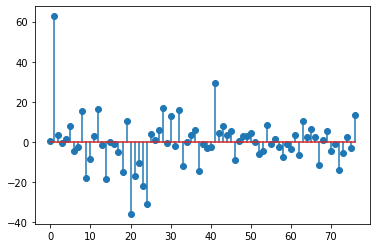

In [10]:
W = logreg.coef_
W = W.ravel()
plt.stem(W)

In [11]:
ind = np.argsort(np.abs(W))
i1 = ind[-1] 
i2 = ind[-2]
name1 = xnames[i1]
name2 = xnames[i2]
print('The two most significant genes are {0:s} and {1:s}'.format(name1,name2))

The two most significant genes are ITSN1_N and BRAF_N


In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support

nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)

prec = []
rec = []
f1 = []
err_rate = []

for Itr, Its in kf.split(Xtr1):
  Xtr_fold = Xtr1[Itr,:]
  ytr_fold = ytr[Itr]
  Xts_fold = Xtr1[Its,:]
  yts_fold = ytr[Its]

  logreg.fit(Xtr_fold, ytr_fold)
  yhat_fold = logreg.predict(Xts_fold)

preci,reci,f1i,_= precision_recall_fscore_support(yts_fold,yhat_fold,average='binary')
prec.append(preci)
rec.append(reci)
f1.append(f1i)
err_rate.append(np.mean(yts_fold != yhat_fold))

prec = np.mean(prec)
rec = np.mean(rec)
f1 = np.mean(f1)
err_mean = np.mean(err_rate)
 
print('Precision = {0:.4f}'.format(prec))
print('Recall = {0:.4f}'.format(rec))
print('f1 = {0:.4f}'.format(f1))
print('error rate = {0:.4f}'.format(err_mean))

Precision = 0.8788
Recall = 0.9667
f1 = 0.9206
error rate = 0.0667


In [13]:
ystr = df1['class'].values
vals, y = np.unique(ystr, return_inverse=True)

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

In [15]:
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=3)

scaler = StandardScaler()
scaler.fit(Xtr)
Xtr1 = scaler.transform(Xtr)
Xts1 = scaler.transform(Xts)

logreg = linear_model.LogisticRegression(solver='liblinear')
logreg.fit(Xtr1,ytr)
yhat = logreg.predict(Xtr1)
acc = np.mean(yhat == ytr)
print('Accuracy on the training data is {0:f}'.format(acc))

print('=========Starting K-Fold===========')
logreg = linear_model.LogisticRegression(solver='liblinear')

ny = np.max(y)
C = np.zeros((ny+1,ny+1))

nfold = 10
kf = KFold(n_splits=nfold, shuffle=True)
err_rate = np.zeros(nfold)

for ifold, Ind in enumerate(kf.split(Xtr1)):
  Itr, Its = Ind
  Xtr_fold = Xtr1[Itr,:]
  ytr_fold = ytr[Itr]
  Xts_fold = Xtr1[Its,:]
  yts_fold = ytr[Its]

  logreg.fit(Xtr_fold, ytr_fold)
  yhat_fold = logreg.predict(Xts_fold)

  C += confusion_matrix(yts_fold,yhat_fold)
  
  err_rate[ifold] = np.mean(yhat_fold != yts_fold)

  Csum = np.sum(C,1)
  C = C / Csum[np.newaxis,:]
  print(np.array_str(C, precision=4, suppress_small=True))

  err_mean = np.mean(err_rate)
  err_se = np.sqrt(nfold)*np.std(err_rate)/np.sqrt(nfold-1)
  print("Error rate = %12.4e, SE=%12.4e" % (err_mean,err_se))

Accuracy on the training data is 1.000000
=========Starting K-Fold===========
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Error rate =   0.0000e+00, SE=  0.0000e+00
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Error rate =   0.0000e+00, SE=  0.0000e+00
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Error rate =   0.0000e+00, SE=  0.0000e+00
[[0.9091 0.     0.     0.     0.0909 0.     0.     0.    ]
 [0.0909 0.9231 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     1.     0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


<StemContainer object of 3 artists>

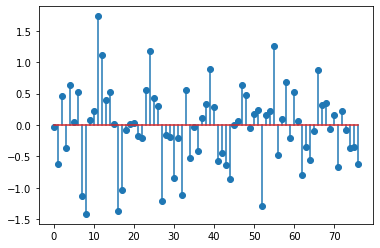

In [16]:
logreg = linear_model.LogisticRegression(solver='liblinear')
logreg.fit(Xtr1,ytr)
W = logreg.coef_
plt.stem(W[0,:])

In [17]:
npen = 20
C_test = np.logspace(-1,3,npen)
nfold = 10

kf = KFold(n_splits=nfold,shuffle=True)
err_rate = np.zeros((npen,nfold))

logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True,solver='liblinear')

for ifold, Ind in enumerate(kf.split(Xtr1)):
  Itr, Its = Ind
  Xtr_fold = Xtr1[Itr,:]
  ytr_fold = ytr[Itr]
  Xts_fold = Xtr1[Its,:]
  yts_fold = ytr[Its]

  for ipen, c in enumerate(C_test):
    logreg.C= c
    logreg.fit(Xtr_fold, ytr_fold)
    
    yhat_fold = logreg.predict(Xts_fold)
    err_rate[ipen,ifold] = np.mean(yhat_fold != yts_fold)

  print("Fold %d" % ifold)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


The minimum test error rate =   1.3263e-02, SE=  3.9753e-03


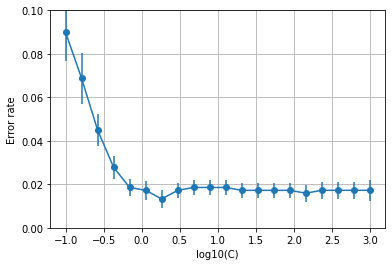

In [18]:
err_mean = np.mean(err_rate, axis=1)
err_se = np.std(err_rate,axis=1)/np.sqrt(nfold-1)

plt.errorbar(np.log10(C_test), err_mean, marker='o',yerr=err_se)
plt.ylim([0,0.1])
plt.grid()
plt.xlabel('log10(C)')
plt.ylabel('Error rate')
imin = np.argmin(err_mean)
print("The minimum test error rate = %12.4e, SE=%12.4e" % (err_mean[imin], err_se[imin]))

In [19]:
err_tgt = err_mean[imin] + err_se[imin]
iopt = np.where(err_mean < err_tgt)[0][0]
C_opt = C_test[iopt]
print("Optimal C=%12.4e" % C_opt)

Optimal C=  1.8330e+00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


Text(0.5, 1.0, 'l1-regularization')

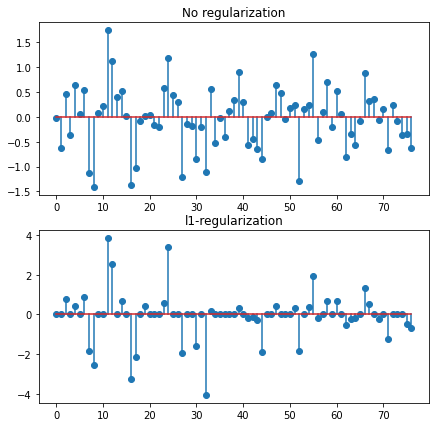

In [20]:
logreg = linear_model. LogisticRegression(C=C_opt,penalty='l1',solver='liblinear')
logreg.C= C_opt
logreg.fit(Xtr1,ytr)

W_l1 = logreg.coef_

plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.stem(W[0,:])
plt.title('No regularization')
plt.subplot(2,1,2)
plt.stem(W_l1[0,:])
plt.title('l1-regularization')